In [55]:
import cobra
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import sys
sys.path.append('../code/')
import leakage
from pathlib import Path
import matplotlib
import seaborn as sns
import scipy.stats as st
from scipy.stats import mannwhitneyu
from matplotlib import cm, colors

# Estimate the ratio of carbon leaked from Paczia et al., 2013

In [2]:
model = cobra.io.read_sbml_model('../models/e_coli/momentiJO1366.xml')
model.solver = 'gurobi'

Set parameter Username
Academic license - for non-commercial use only - expires 2024-02-26


# Shared colours for bar chart

In [53]:
l = ['Pyruvate', 'Uracil', 'Acetate', 'Glucose', 'Ethanol', 'Glycine', 'Lysine', 'Phenylalanine', 'Glucose-6-phosphate', 
        'Citrate', 'Orotate', 'alpha-ketoglutarate']
l.sort()
l.append('Other')
colors1 = {k: plt.cm.tab20(i) for i, k in enumerate(l)}



In [151]:
mapping_df = pd.read_csv('../data/id_mapping.csv', index_col=0)
# mapping_df.index = [x.strip('\t').replace(" MS", "") for x in mapping_df.index]
met_abrv_to_id = mapping_df['Ecoli metabolite'].to_dict()
met_abrv_to_name = mapping_df['Metabolite name'].to_dict()


## E. coli

In [152]:
data_folder =  Path("../data/e_coli/")
organism = 'e_coli'

In [168]:
exometabolites_folder = Path(data_folder)

# Filenames
fn_exometabolites = exometabolites_folder / "{0}_exometabolites.csv".format(organism)
fn_exometabolites_std = exometabolites_folder / "{0}_exometabolites_std.csv".format(organism)
fn_OD = exometabolites_folder / "{0}_OD.csv".format(organism)
fn_glucose = exometabolites_folder / "{0}_glucose.csv".format(organism)

# Read files as dataframes
df_exometabolites = pd.read_csv(fn_exometabolites, index_col=0)
df_exometabolites_std = pd.read_csv(fn_exometabolites_std, index_col=0)
df_OD = pd.read_csv(fn_OD, index_col=0)

In [169]:
df_glucose = pd.read_csv(fn_glucose, index_col=0)
df_glucose.loc[0,:]=[20,0] # From paper (in g/L)

In [170]:
Mw_glc = 180.156
df_glucose['N carbons'] = 6*df_glucose['Glucose mean']/Mw_glc

In [171]:
# df_eexometabolites is in uM
df_exometabolites.loc[0,:]=0 # Assume none of the byproducts are present at start of cultivation

In [157]:
df_exometabolites

,G6P,F6P,FBP,DHAP,GA3P,23PG,PEP,R5P,RU5P+X5P,E4P,...,LEU,TRP,HIS,ARG,PYR,ORO,FUM,URA,AKG,ACT
Time,,,,,,,,,,,,,,,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,0.0,0.00
1,0.101467,0.446667,0.000000,0.190667,0.024512,0.054400,0.000000,0.003685,0.000000,0.000000,...,0.041667,0.031867,4.690000,0.138467,0.00,8.00,13.50,88.50,0.0,444.00
2,0.277733,0.782667,0.000000,0.533333,0.009140,0.096667,0.000000,0.017333,0.000000,0.000000,...,0.039967,0.035833,3.856667,0.619000,36.75,15.25,1.25,4.25,0.0,415.00
3,0.362400,0.693333,0.000000,0.828000,0.038120,0.084267,0.000000,0.077600,0.000000,0.000000,...,0.067167,0.042067,3.950000,1.556667,31.75,16.25,1.25,30.75,0.0,328.25
4,0.704000,0.957333,0.000000,1.770667,0.064667,0.093333,0.063280,0.155067,0.052933,0.000000,...,0.105600,0.052033,4.856667,2.943333,34.75,10.25,0.00,46.25,0.0,243.50
5,1.450667,2.194667,0.000000,3.138667,0.197600,0.442667,0.189867,0.302667,0.136533,0.000000,...,0.156000,0.068833,5.670000,4.753333,492.25,147.75,1.00,7.25,0.0,2931.50
6,2.996000,5.760000,0.000000,6.733333,0.666667,1.397333,0.596000,0.881333,0.409467,0.000000,...,0.231333,0.084900,6.493333,6.923333,1686.50,434.00,2.00,48.50,0.0,7585.00
7,6.520000,9.453333,0.000000,11.173333,1.513333,3.140000,1.098667,1.832000,0.744000,0.121333,...,0.347667,0.098767,6.833333,9.613333,2636.00,583.00,2.50,18.50,0.0,8945.50
8,10.720000,18.346667,6.293333,17.733333,3.941333,5.866667,1.820000,2.498667,1.136000,0.400400,...,0.727667,0.112333,6.840000,8.873333,4924.00,998.00,5.00,30.00,5.5,12948.50


In [158]:
df_exometabolites.columns

Index(['G6P', 'F6P', 'FBP', 'DHAP', 'GA3P', '23PG', 'PEP', 'R5P', 'RU5P+X5P',
       'E4P', 'CIT', 'ACN', 'ICIT', 'AKG MS', 'FUM MS', 'OAS', 'GLU', 'SER',
       'ASP', 'THR', 'HOM', 'TYR', 'GLY', 'PRO', 'ALA', 'MET', 'VAL', 'PHE',
       'ILEU', 'LEU', 'TRP', 'HIS', 'ARG', 'PYR', 'ORO', 'FUM', 'URA', 'AKG',
       'ACT'],
      dtype='object')

In [172]:
# met_abbreviations = [x.replace(" MS", "") for x in df_exometabolites.columns]
cmap = colors.ListedColormap(cm.tab20b.colors + cm.tab20c.colors, name='tab40')#[4:]
all_names  = [met_abrv_to_name[x] for x in df_exometabolites.columns if isinstance(met_abrv_to_name[x], str)]
all_names.sort()
all_names = ['Glucose'] + all_names + ['Other']
colors2 = {k: cmap(i) for i, k in enumerate(all_names)}
colors2['Ethanol'] = 'darkblue'
colors2['Glucose'] = 'darkorange'
colors2['Other'] = 'y'
colors2['Succinate'] = 'pink'


In [205]:
colors2['Asparagine'] = 'peru'
colors2['Glutamine'] = 'maroon'
colors2['Leucine/Isoleucine'] = 'brown'
colors2['Lysine'] = 'navy'
colors2['Shikimate'] = 'gray'


## map all units to mol/L carbon

In [38]:
n_carbon_dict = {}
for col in df_exometabolites.columns:
    try:
        keys = [x.strip() for x in met_abrv_to_id[col].split(',')]
    except AttributeError:
        print('{0} not parsed into n_carbons'.format(col))
        continue
    else:
        n_carbon = 0
        for m_id in keys:
            m = model.metabolites.get_by_id('{0}_c'.format(m_id))
            n_carbon += m.elements['C']
        n_carbon = n_carbon/len(keys)
        n_carbon_dict[col] = n_carbon * df_exometabolites[col] *1e-6 # Convert from uM to M
    

AKG MS not parsed into n_carbons
FUM MS not parsed into n_carbons


In [39]:
df_exo_n_carbons = pd.DataFrame(n_carbon_dict, index = df_exometabolites.index)
# print([met_abrv_to_id[x] for x in df_exo_n_carbons.columns])

df_exo_n_carbons.columns = [met_abrv_to_name[x] for x in df_exo_n_carbons.columns]

['g6p', 'f6p', 'fdp', 'dhap', 'g3p', '2pg, 3pg', 'pep', 'r5p', 'ru5p__D, ru5p__L, xu5p__D, xu5p__L', 'e4p', 'cit', 'acon_C', 'icit', 'oaa', 'glu__L', 'ser__L', 'asp__L', 'thr__L', 'hom__L', 'tyr__L', 'gly', 'pro__L', 'ala__L', 'met__L', 'val__L', 'phe__L', 'ile__L', 'leu__L', 'trp__L', 'his__L', 'arg__L', 'pyr', 'orot', 'fum', 'ura', 'akg', 'ac']


In [40]:
glc_carbons_consumed = df_glucose.loc[0, 'N carbons'] - df_glucose.loc[:, 'N carbons']
carbons_in_medium = df_exo_n_carbons.sum(axis=1)

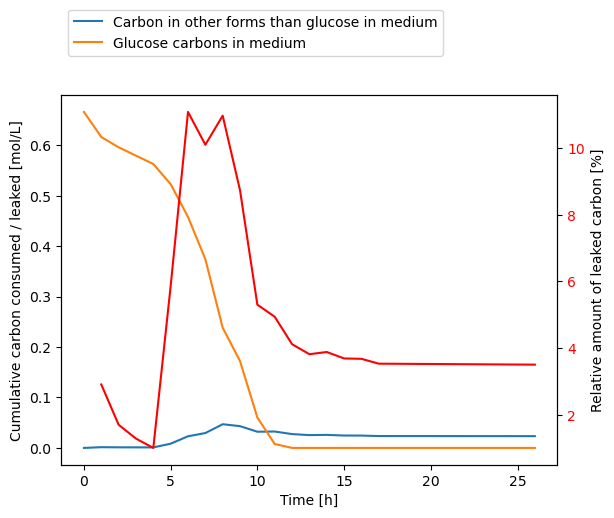

In [41]:
fig, ax = plt.subplots(1)
ax.plot(df_glucose.index, carbons_in_medium, label = 'Carbon in other forms than glucose in medium')
ax.plot(df_glucose.index,df_glucose.loc[:, 'N carbons'], label = "Glucose carbons in medium")
ax2 = ax.twinx()
ax2.plot(df_glucose.index, 100*carbons_in_medium/glc_carbons_consumed, label = 'Relative amount of leaked carbon', c = 'r')
ax.legend(loc = 'upper left', bbox_to_anchor=(0, 1.25))
ax.set_xlabel('Time [h]')
ax.set_ylabel('Cumulative carbon consumed / leaked [mol/L]')
ax2.set_ylabel('Relative amount of leaked carbon [%]')
ax2.tick_params(axis='y', labelcolor='r')

In [121]:
other_idx = df_exo_n_carbons.sum()/df_exo_n_carbons.sum().sum() < 0.01
# other_idx = df_exo_n_carbons.divide(df_exo_n_carbons.sum(axis = 1), axis = 0).max()<0.05
df_exo_carbon_others = df_exo_n_carbons.loc[:, ~other_idx].copy()
df_exo_carbon_others.loc[:,'Other'] = df_exo_n_carbons.loc[:, other_idx].sum(axis=1)
df_exo_carbon_others_only = df_exo_n_carbons.loc[:, other_idx]

In [122]:
df_exo_carbon_others.columns

Index(['Citrate', 'Pyruvate', 'Orotate', 'Uracil', 'alpha-ketoglutarate',
       'Acetate', 'Other'],
      dtype='object')

Text(0, 0.5, 'Carbon in medium except glucose [mol/L]')

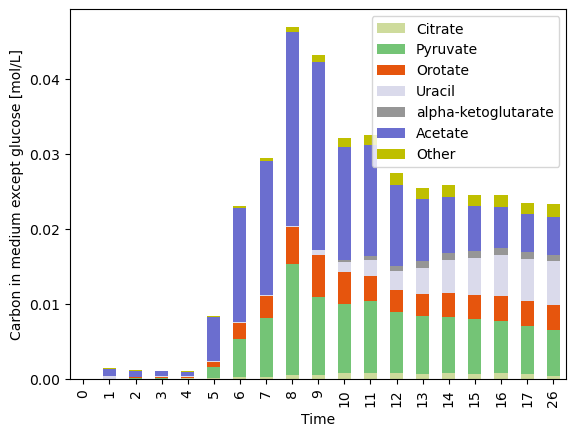

In [123]:
ax = df_exo_carbon_others.plot(kind='bar', stacked=True, color = colors2)
ax.set_ylabel("Carbon in medium except glucose [mol/L]")

Text(0.5, 0, 'Time [h]')

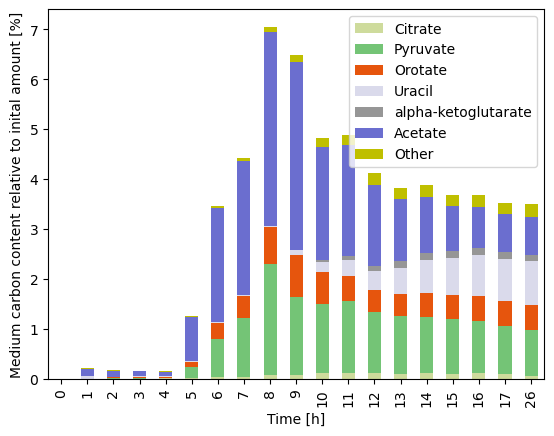

In [124]:
df_exo_carbon_others_norm = 100*df_exo_carbon_others/df_glucose['N carbons'].max()
ax = df_exo_carbon_others_norm.plot(kind='bar', stacked=True, color = colors2)
ax.set_ylabel("Medium carbon content relative to inital amount [%]")
ax.set_xlabel("Time [h]")

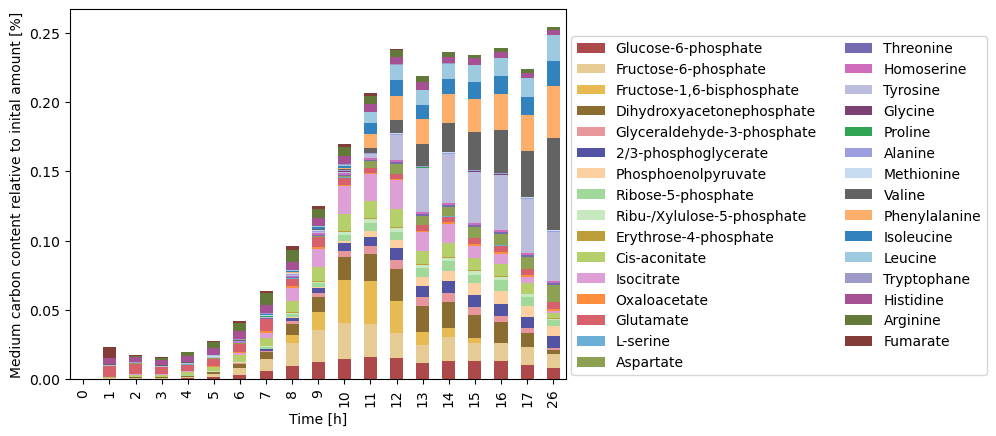

In [125]:
tmp = 100*df_exo_n_carbons.loc[:, other_idx]/df_glucose['N carbons'].max()
# cmap = colors.ListedColormap(cm.tab20b.colors[4:] + cm.tab20c.colors, name='tab40')
ax = tmp.plot(kind='bar', stacked=True, color = colors2)
ax.set_ylabel("Medium carbon content relative to inital amount [%]")
ax.set_xlabel("Time [h]")
ax.legend(loc=(1.01, 0.01), ncol=2)

Text(0, 0.5, 'Carbon in medium [mol/L]')

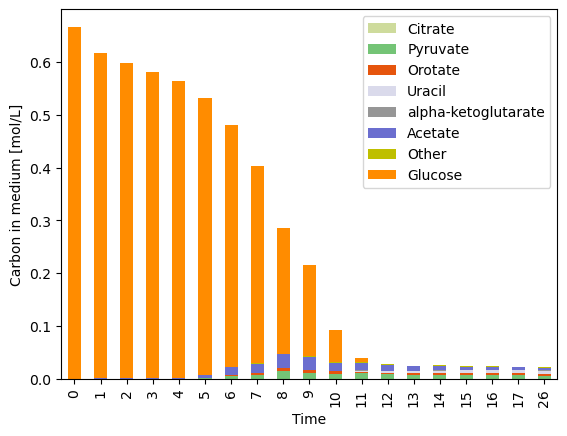

In [126]:
df_exo_carbon_others['Glucose'] = df_glucose['N carbons']
ax = df_exo_carbon_others.plot(kind='bar', stacked=True, color = colors2)
ax.set_ylabel("Carbon in medium [mol/L]")

Text(0, 0.5, 'Relative amount of initial carbon in medium [%]')

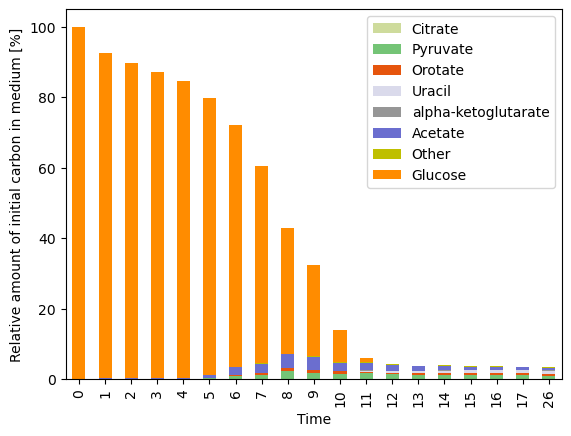

In [130]:
df_exo_carbon_others_norm['Glucose'] = 100*df_glucose['N carbons']/df_glucose['N carbons'].max()
ax = df_exo_carbon_others_norm.plot(kind='bar', stacked=True, color = colors2)
ax.set_ylabel("Relative amount of initial carbon in medium [%]")

In [147]:
# df_exo_n_carbons.plot(kind='bar', stacked=True)

In [128]:
df_exo_n_carbons['Glucose'] = df_glucose['N carbons']

Text(0, 0.5, 'Change in extracellular carbon [Rel. to initial [%]]')

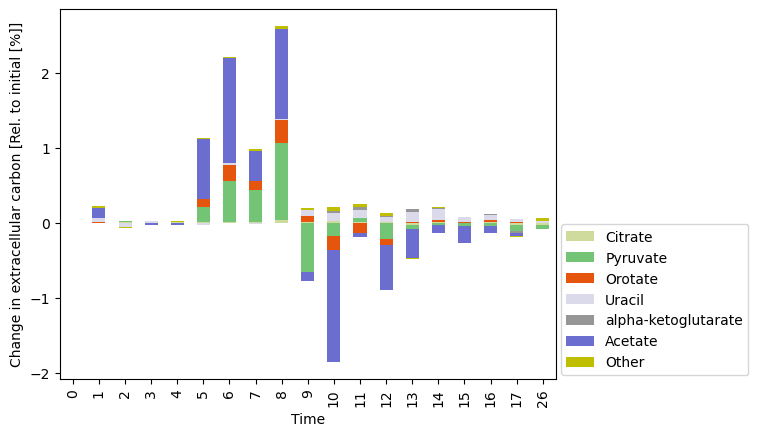

In [132]:
df_diff = df_exo_carbon_others_norm.diff()
df_diff.drop(columns='Glucose', inplace=True)
timestep = np.diff(df_exo_carbon_others.index)
ax = df_diff.plot(kind='bar', stacked=True, color = colors2)
ax.legend(loc=(1.01, 0.01), ncol=1)
ax.set_ylabel('Change in extracellular carbon [Rel. to initial [%]]')


Text(0, 0.5, 'Change in extracellular concentration [Relative amount of initial carbon in medium [%]]')

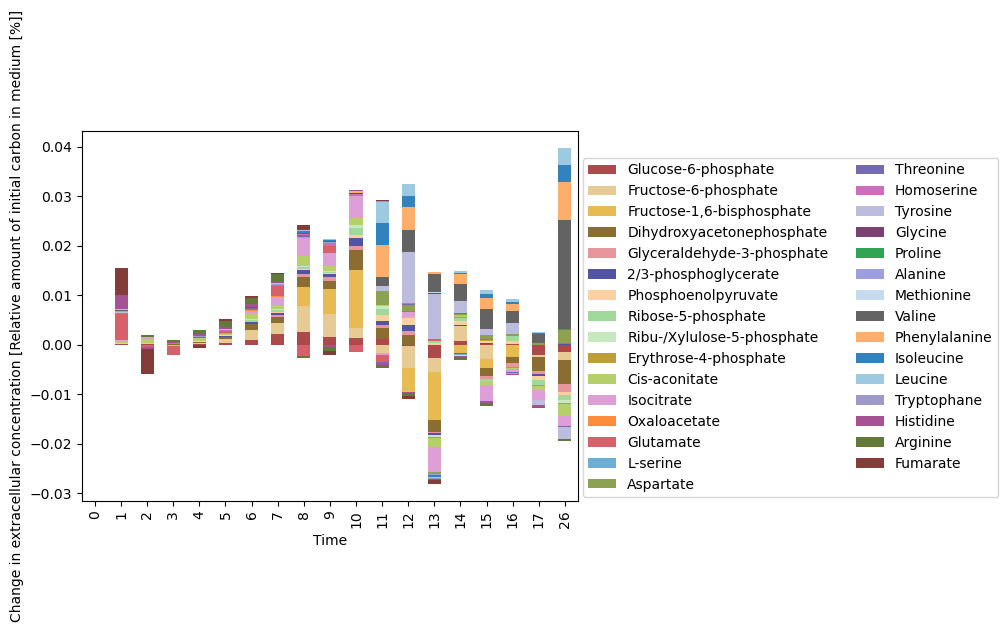

In [115]:
df_diff = df_exo_n_carbons.loc[:, other_idx].diff()*100
timestep = np.diff(df_exo_carbon_others.index)
ax = df_diff.plot(kind='bar', stacked=True, color = colors2)
ax.legend(loc=(1.01, 0.01), ncol=2)
ax.set_ylabel('Change in extracellular concentration [Relative amount of initial carbon in medium [%]]')

In [29]:
# leaked = (df_diff[df_diff>0].sum(1))[1:]/timestep

In [30]:
# consumed = (df_diff[df_diff<0].sum(1)*-1)[1:]/timestep

Text(0, 0.5, 'Relative carbon [%]')

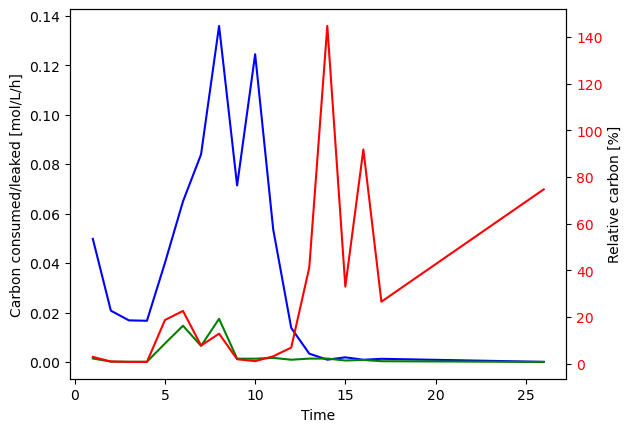

In [31]:
fig, ax = plt.subplots(1)
ax2 = ax.twinx()
consumed.plot(ax=ax, c = 'b')
leaked.plot(ax=ax, label = 'Leaked', c = 'g')
(100*leaked/consumed).plot(ax=ax2, c = 'r')
ax2.tick_params(axis='y', labelcolor='r')
ax.set_ylabel('Carbon consumed/leaked [mol/L/h]')
ax2.set_ylabel('Relative carbon [%]')

## Yeast

In [301]:
data_folder =  Path("../data/yeast/")
organism = 'yeast'

In [302]:
exometabolites_folder = Path(data_folder)

# Filenames
fn_exometabolites = exometabolites_folder / "{0}_exometabolites.csv".format(organism)
fn_exometabolites_std = exometabolites_folder / "{0}_exometabolites_std.csv".format(organism)
fn_OD = exometabolites_folder / "{0}_OD.csv".format(organism)
fn_glucose = exometabolites_folder / "{0}_glucose.csv".format(organism)

# Read files as dataframes
df_exometabolites = pd.read_csv(fn_exometabolites, index_col=0)
df_exometabolites_std = pd.read_csv(fn_exometabolites_std, index_col=0)
df_OD = pd.read_csv(fn_OD, index_col=0)

In [303]:
df_glucose = pd.read_csv(fn_glucose, index_col=0)
df_glucose.loc[0,:]=[16,0] # From paper (in g/L)

In [304]:
Mw_glc = 180.156
df_glucose['N carbons'] = 6*df_glucose['Glucose mean']/Mw_glc

In [305]:
# df_eexometabolites is in uM
df_exometabolites.loc[0,:]=0 # Assume none of the byproducts are present at start of cultivation

In [306]:
df_exometabolites

,G6P,F6P,FBP,DHAP,23PG,PEP,PYR MS,RU5P+X5P,CIT,ACN,...,LYS,ARG,PYR,ORO,FUM,URA,AKG,SHI,ACT,ETH
Time,,,,,,,,,,,,,,,,,,,,,
0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.00,0.00,0.00,0.0,0.00,0.0,0.000,0.000
1,0.000,0.109,4.000,0.006,0.000,0.000,66.400,0.000,0.000,0.000,...,0.943,0.000,13.75,2.00,0.00,20.0,4.75,0.0,0.000,9333.623
2,0.000,0.127,6.973,0.036,0.000,0.000,152.000,0.000,0.000,0.000,...,1.404,4.040,103.25,6.25,0.00,5.5,17.25,0.0,546.250,16171.044
3,0.000,0.141,8.373,0.052,0.000,0.000,230.800,0.000,0.000,0.000,...,1.577,24.460,189.50,7.25,0.00,6.0,17.75,0.0,977.250,25396.136
4,0.014,0.181,8.213,0.108,0.000,0.000,373.467,0.000,0.656,0.000,...,1.572,0.198,317.50,9.50,0.50,7.5,22.75,0.0,1696.250,32776.210
5,0.078,0.189,10.027,0.256,0.000,0.000,652.000,0.000,3.357,0.000,...,1.469,7.760,303.75,7.50,0.75,29.5,14.50,0.0,1823.225,61862.383
6,0.099,0.245,10.293,0.321,0.431,0.000,861.333,0.000,5.107,0.021,...,1.051,0.000,734.50,16.50,2.00,10.5,35.50,0.0,3628.000,96049.490
7,0.181,0.294,11.427,0.379,0.513,0.000,462.667,0.005,6.880,0.095,...,1.711,3.880,379.00,11.50,2.00,13.0,40.50,0.0,5530.000,99305.405
8,0.245,0.304,9.760,0.312,0.341,0.000,5.107,0.002,5.667,0.079,...,2.511,0.000,0.00,11.50,2.50,19.5,46.50,0.0,7034.000,87367.050


In [307]:
df_exometabolites.columns

Index(['G6P', 'F6P', 'FBP', 'DHAP', '23PG', 'PEP', 'PYR MS', 'RU5P+X5P', 'CIT',
       'ACN', 'ICIT', 'AKG MS', 'SUC', 'FUM MS', 'ASN', 'GLU', 'SER', 'ASP',
       'GLN', 'TYR', 'PRO', 'ALA', 'MET', 'VAL', 'PHE', 'LEU+ILEU', 'HIS',
       'LYS', 'ARG', 'PYR', 'ORO', 'FUM', 'URA', 'AKG', 'SHI', 'ACT', 'ETH'],
      dtype='object')

In [308]:
# met_abbreviations = [x.replace(" MS", "") for x in df_exometabolites.columns]

## map all units to mol/L carbon

In [309]:
n_carbon_dict = {}
for col in df_exometabolites.columns:
    try:
        keys = [x.strip() for x in met_abrv_to_id[col].split(',')]
    except (AttributeError, KeyError) as e:
        print('{0} not parsed into n_carbons'.format(col))
        continue
    else:
        n_carbon = 0
        for m_id in keys:
            m = model.metabolites.get_by_id('{0}_c'.format(m_id))
            n_carbon += m.elements['C']
        n_carbon = n_carbon/len(keys)
        n_carbon_dict[col] = n_carbon * df_exometabolites[col] *1e-6 # Convert from uM to M
    

PYR MS not parsed into n_carbons
AKG MS not parsed into n_carbons
FUM MS not parsed into n_carbons


In [310]:
df_exo_n_carbons = pd.DataFrame(n_carbon_dict, index = df_exometabolites.index)
df_exo_n_carbons.columns = [met_abrv_to_name[x] for x in df_exo_n_carbons.columns]

In [311]:
# df_exo_n_carbons.loc[0,:] = 0

In [312]:
glc_carbons_consumed = df_glucose.loc[0, 'N carbons'] - df_glucose.loc[:, 'N carbons']
carbons_in_medium = df_exo_n_carbons.sum(axis=1)

(0.0, 100.0)

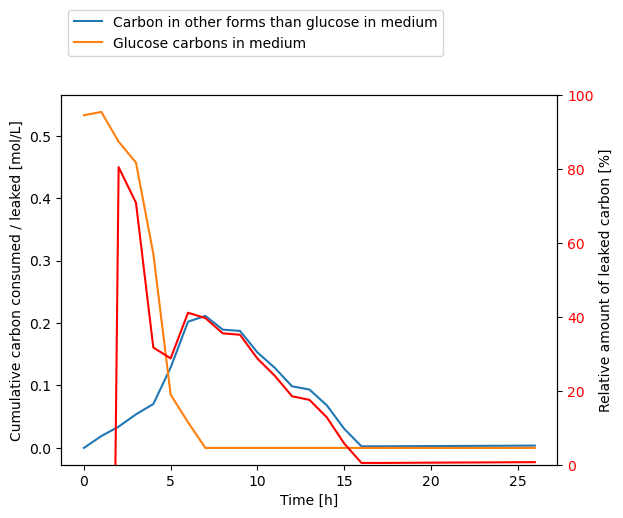

In [313]:
fig, ax = plt.subplots(1)
ax.plot(df_glucose.index, carbons_in_medium, label = 'Carbon in other forms than glucose in medium')
ax.plot(df_glucose.index,df_glucose.loc[:, 'N carbons'], label = "Glucose carbons in medium")
ax2 = ax.twinx()
ax2.plot(df_glucose.index, 100*carbons_in_medium/glc_carbons_consumed, label = 'Relative amount of leaked carbon', c = 'r')
ax.legend(loc = 'upper left', bbox_to_anchor=(0, 1.25))
ax.set_xlabel('Time [h]')
ax.set_ylabel('Cumulative carbon consumed / leaked [mol/L]')
ax2.set_ylabel('Relative amount of leaked carbon [%]')
ax2.tick_params(axis='y', labelcolor='r')
ax2.set_ylim(0, 100)


In [314]:
other_idx = df_exo_n_carbons.sum()/df_exo_n_carbons.sum().sum() < 0.01
# other_idx = df_exo_n_carbons.divide(df_exo_n_carbons.sum(axis = 1), axis = 0).max()<0.05

df_exo_carbon_others = df_exo_n_carbons.loc[:, ~other_idx].copy()
df_exo_carbon_others.loc[:,'Other'] = df_exo_n_carbons.loc[:, other_idx].sum(axis=1)


Text(0, 0.5, 'Carbon in medium except glucose [mol/L]')

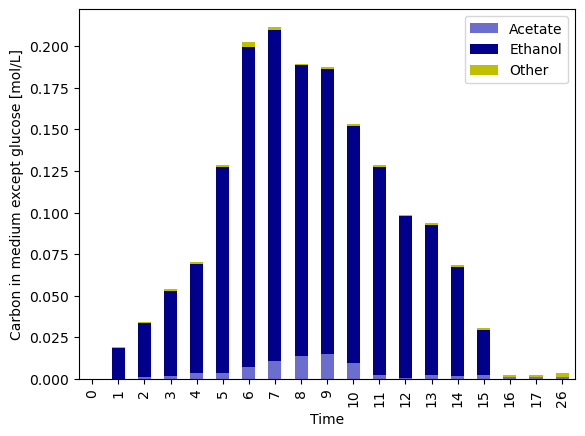

In [315]:
ax = df_exo_carbon_others.plot(kind='bar', stacked=True, color = colors2)
ax.set_ylabel("Carbon in medium except glucose [mol/L]")

Text(0, 0.5, 'Relative amount of initial carbon in medium [%]')

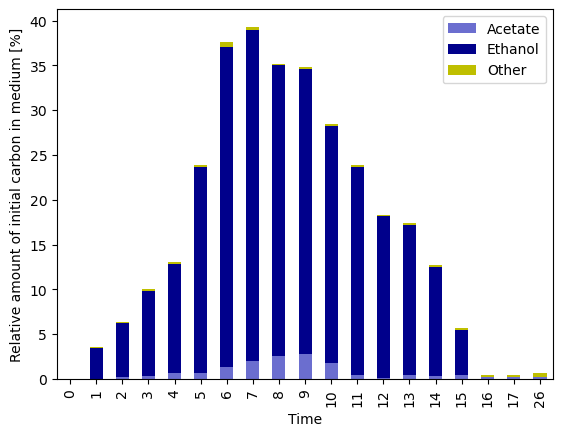

In [316]:
df_exo_carbon_others_norm = 100*df_exo_carbon_others/df_glucose['N carbons'].max()
ax = df_exo_carbon_others_norm.plot(kind='bar', stacked=True, color = colors2)
ax.set_ylabel("Relative amount of initial carbon in medium [%]")

Text(0, 0.5, 'Carbon in medium [mol/L]')

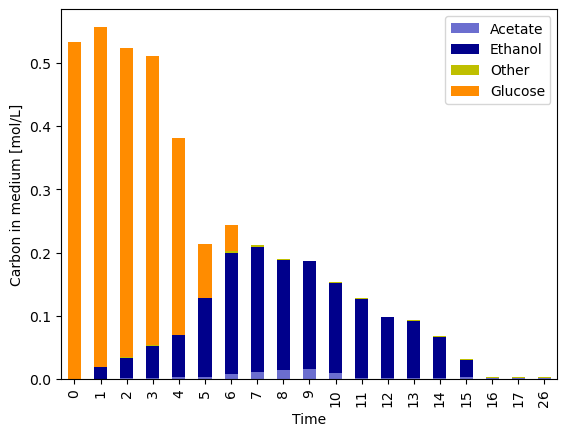

In [317]:
df_exo_carbon_others['Glucose'] = df_glucose['N carbons']
ax = df_exo_carbon_others.plot(kind='bar', stacked=True, color = colors2)
ax.set_ylabel("Carbon in medium [mol/L]")

Text(0, 0.5, 'Relative amount of initial carbon in medium [%]')

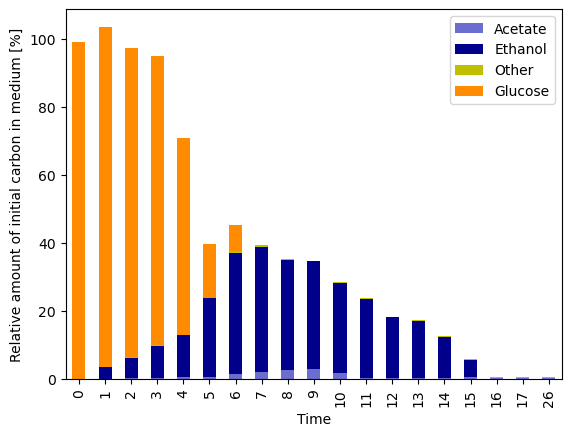

In [318]:
df_exo_carbon_others_norm['Glucose'] = 100*df_glucose['N carbons']/df_glucose['N carbons'].max()
ax = df_exo_carbon_others_norm.plot(kind='bar', stacked=True, color = colors2)
ax.set_ylabel("Relative amount of initial carbon in medium [%]")

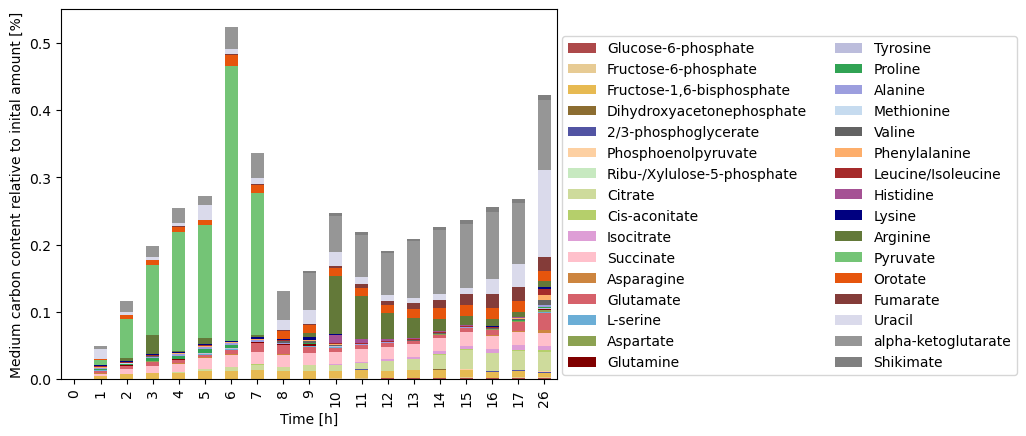

In [319]:
tmp = 100*df_exo_n_carbons.loc[:, other_idx]/df_glucose['N carbons'].max()
# cmap = colors.ListedColormap(cm.tab20b.colors[4:] + cm.tab20c.colors, name='tab40')
ax = tmp.plot(kind='bar', stacked=True, color = colors2)
ax.set_ylabel("Medium carbon content relative to inital amount [%]")
ax.set_xlabel("Time [h]")
ax.legend(loc=(1.01, 0.01), ncol=2)

Text(0, 0.5, 'Change in extracellular carbon [Rel. to initial [%]]')

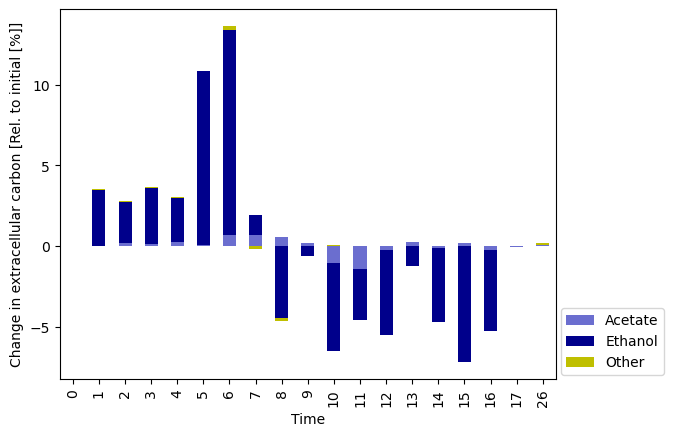

In [193]:
df_diff = df_exo_carbon_others_norm.diff()
df_diff.drop(columns='Glucose', inplace=True)
timestep = np.diff(df_exo_carbon_others.index)
ax = df_diff.plot(kind='bar', stacked=True, color = colors2)
ax.legend(loc=(1.01, 0.01), ncol=1)
ax.set_ylabel('Change in extracellular carbon [Rel. to initial [%]]')


Text(0, 0.5, 'Change in extracellular concentration [Rel. inital C [%]]')

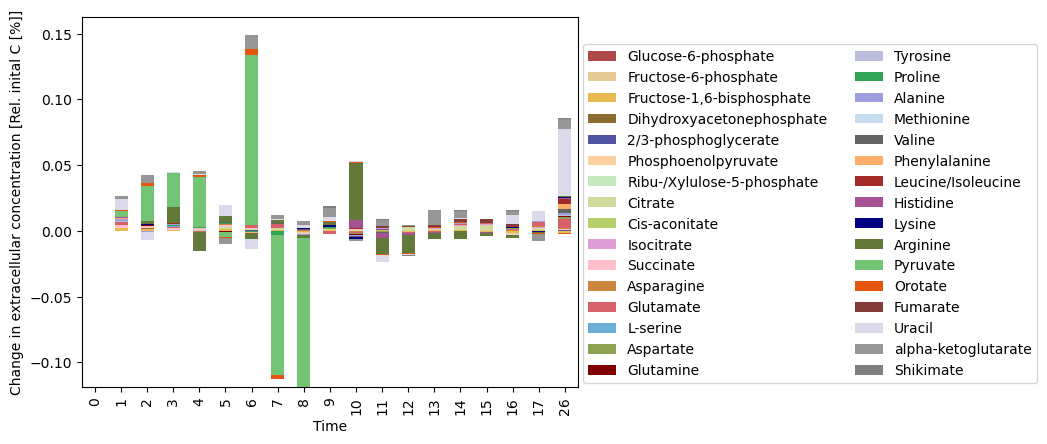

In [320]:
df_diff = df_exo_n_carbons.loc[:, other_idx].diff()*100
timestep = np.diff(df_exo_carbon_others.index)
ax = df_diff.plot(kind='bar', stacked=True, color = colors2)
ax.legend(loc=(1.01, 0.01), ncol=2)
ax.set_ylabel('Change in extracellular concentration [Rel. inital C [%]]')

In [52]:
df_exo_n_carbons['Glucose'] = df_glucose['N carbons']

In [53]:
df_diff = df_exo_n_carbons.diff()
timestep = np.diff(df_exo_carbon_others.index)

In [54]:
leaked = (df_diff[df_diff>0].sum(1))[1:]/timestep

In [55]:
consumed = (df_diff[df_diff<0].sum(1)*-1)[1:]/timestep

(0.0, 100.0)

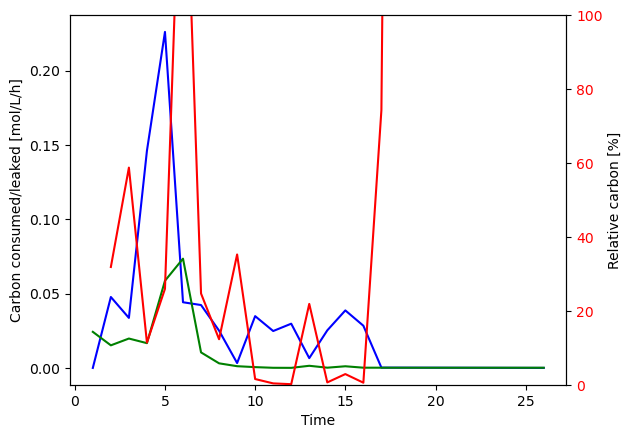

In [56]:
fig, ax = plt.subplots(1)
ax2 = ax.twinx()
consumed.plot(ax=ax, c = 'b')
leaked.plot(ax=ax, label = 'Leaked', c = 'g')
(100*leaked/consumed).plot(ax=ax2, c = 'r')
# plt.legend()
ax2.tick_params(axis='y', labelcolor='r')
ax.set_ylabel('Carbon consumed/leaked [mol/L/h]')
ax2.set_ylabel('Relative carbon [%]')
ax2.set_ylim(0,100)
# ax2.set_xlim(0,72)

## C. glutamicum

In [321]:
organism = 'c_glutamicum'
data_folder =  Path("../data/{0}/".format(organism))


In [322]:
exometabolites_folder = Path(data_folder)

# Filenames
fn_exometabolites = exometabolites_folder / "{0}_exometabolites.csv".format(organism)
fn_exometabolites_std = exometabolites_folder / "{0}_exometabolites_std.csv".format(organism)
fn_OD = exometabolites_folder / "{0}_OD.csv".format(organism)
fn_glucose = exometabolites_folder / "{0}_glucose.csv".format(organism)

# Read files as dataframes
df_exometabolites = pd.read_csv(fn_exometabolites, index_col=0)
df_exometabolites_std = pd.read_csv(fn_exometabolites_std, index_col=0)
df_OD = pd.read_csv(fn_OD, index_col=0)

In [323]:
df_glucose = pd.read_csv(fn_glucose, index_col=0)
df_glucose.loc[0,:]=[10,0] # From paper (in g/L)

In [324]:
Mw_glc = 180.156
df_glucose['N carbons'] = 6*df_glucose['Glucose mean']/Mw_glc

In [325]:
# df_eexometabolites is in uM
df_exometabolites.loc[0,:]=0 # Assume none of the byproducts are present at start of cultivation

In [326]:
df_exometabolites

,G6P,F6P,FBP,DHAP,GA3P,23PG,R5P,RU5P+X5P,S7P,E4P,...,GLN,HOM,TYR,GLY,PRO,ALA,MET,VAL,ARG,LYS
Time,,,,,,,,,,,,,,,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
11,0.280000,0.139000,0.676000,1.171000,0.044000,0.268000,0.059000,0.083000,0.057000,0.087000,...,0.051867,0.676933,0.000000,21.657333,0.764533,5.220000,0.000000,0.000000,NaN,236.100000
12,0.449000,0.302000,1.043000,1.566000,0.069000,0.558000,0.089000,0.104000,0.071000,0.036000,...,0.324933,1.264667,0.000000,55.202667,1.504533,6.480000,0.000000,0.000000,NaN,413.166667
13,0.868000,0.467000,1.419000,2.226000,0.070000,1.015000,0.126000,0.132000,0.100000,0.100000,...,0.458267,1.676667,0.000000,83.602667,2.397867,7.080000,0.000000,0.000000,NaN,628.500000
14,1.156000,0.583000,1.868000,2.972000,0.103000,1.152000,0.177000,0.186000,0.151000,0.249000,...,0.647600,2.202000,0.000000,93.736000,4.531200,7.746667,0.000000,0.000000,NaN,963.166667
15,1.831000,0.874000,2.087000,4.307000,0.155000,1.836000,0.242000,0.202000,0.207000,0.427000,...,1.331600,3.230000,0.000000,174.136000,8.704533,10.280000,0.000000,0.000000,NaN,1459.166667
16,2.484000,1.095000,2.369000,5.747000,0.241000,3.292000,0.382000,0.246000,0.264000,0.799000,...,3.355600,4.528667,0.000000,227.069333,15.744533,14.613333,0.000000,0.000000,NaN,2188.500000
17,2.880000,1.447000,2.593000,7.880000,0.369000,4.696000,0.538000,0.340000,0.381000,1.328000,...,10.487600,6.862000,0.000000,325.469333,34.691200,22.653333,0.000000,0.000000,NaN,3152.500000
18,3.559000,1.600000,2.701000,8.654000,0.457000,6.856000,0.583000,0.360000,0.425000,2.472000,...,0.287600,5.048667,0.000000,329.469333,7.024533,8.826667,0.000000,0.000000,NaN,4063.166667


In [327]:
df_exometabolites.columns

Index(['G6P', 'F6P', 'FBP', 'DHAP', 'GA3P', '23PG', 'R5P', 'RU5P+X5P', 'S7P',
       'E4P', 'ASN', 'GLU', 'SER', 'THR', 'GLN', 'HOM', 'TYR', 'GLY', 'PRO',
       'ALA', 'MET', 'VAL', 'ARG', 'LYS'],
      dtype='object')

In [328]:
# met_abbreviations = [x.replace(" MS", "") for x in df_exometabolites.columns]

## map all units to mol/L carbon

In [329]:
n_carbon_dict = {}
for col in df_exometabolites.columns:
    try:
        keys = [x.strip() for x in met_abrv_to_id[col].split(',')]
    except (AttributeError, KeyError) as e:
        print('{0} not parsed into n_carbons'.format(col))
        continue
    else:
        n_carbon = 0
        for m_id in keys:
            m = model.metabolites.get_by_id('{0}_c'.format(m_id))
            n_carbon += m.elements['C']
        n_carbon = n_carbon/len(keys)
        n_carbon_dict[col] = n_carbon * df_exometabolites[col] *1e-6 # Convert from uM to M
    

S7P not parsed into n_carbons


In [330]:
df_exo_n_carbons = pd.DataFrame(n_carbon_dict, index = df_exometabolites.index)
df_exo_n_carbons.columns = [met_abrv_to_name[x] for x in df_exo_n_carbons.columns]

In [331]:
# df_exo_n_carbons.loc[0,:] = 0

In [332]:
glc_carbons_consumed = df_glucose.loc[0, 'N carbons'] - df_glucose.loc[:, 'N carbons']
carbons_in_medium = df_exo_n_carbons.sum(axis=1)

(0.0, 100.0)

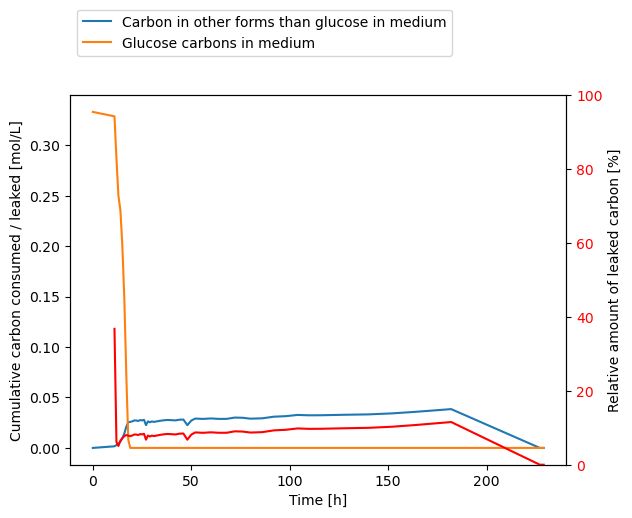

In [333]:
fig, ax = plt.subplots(1)
ax.plot(df_glucose.index, carbons_in_medium, label = 'Carbon in other forms than glucose in medium')
ax.plot(df_glucose.index,df_glucose.loc[:, 'N carbons'], label = "Glucose carbons in medium")
ax2 = ax.twinx()
ax2.plot(df_glucose.index, 100*carbons_in_medium/glc_carbons_consumed, label = 'Relative amount of leaked carbon', c = 'r')
ax.legend(loc = 'upper left', bbox_to_anchor=(0, 1.25))
ax.set_xlabel('Time [h]')
ax.set_ylabel('Cumulative carbon consumed / leaked [mol/L]')
ax2.set_ylabel('Relative amount of leaked carbon [%]')
ax2.tick_params(axis='y', labelcolor='r')
ax2.set_ylim(0, 100)


In [360]:
other_idx = df_exo_n_carbons.max()/df_exo_n_carbons.sum().sum() < 0.01
df_exo_carbon_others = df_exo_n_carbons.loc[:, ~other_idx].copy()
df_exo_carbon_others.loc[:,'Other'] = df_exo_n_carbons.loc[:, other_idx].sum(axis=1)
# df_exo_carbon_others.dropna(inplace=True, axis = 1)


In [361]:
df_exo_carbon_others.dropna(axis=0, inplace=True)
df_exo_carbon_others

,Lysine,Other
Time,,
0,0.000000,0.000000
11,0.001417,0.000187
12,0.002479,0.000362
13,0.003771,0.000448
14,0.005779,0.000545
15,0.008755,0.000832
16,0.013131,0.001181
17,0.018915,0.002013
18,0.024379,0.001157


Text(0, 0.5, 'Carbon in medium except glucose [mol/L]')

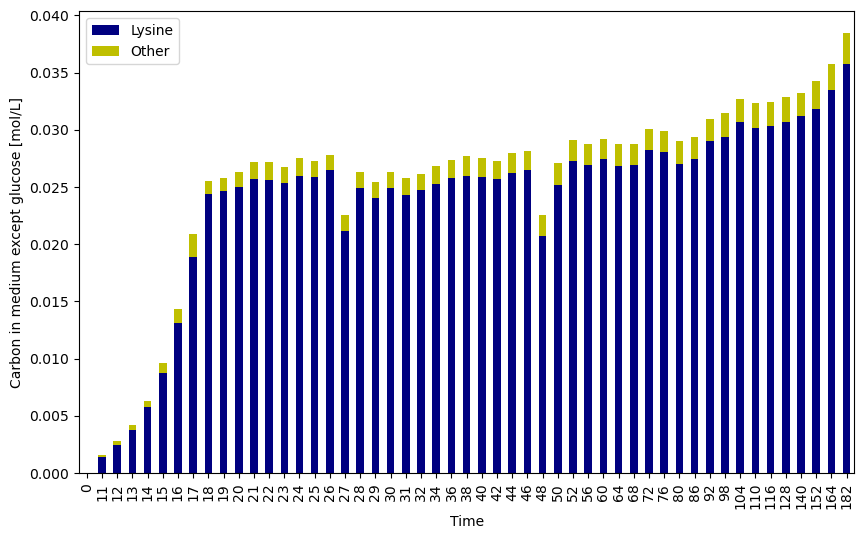

In [362]:
ax = df_exo_carbon_others.plot(kind='bar', stacked=True, color = colors2, figsize = (10,6))
ax.set_ylabel("Carbon in medium except glucose [mol/L]")

Text(0, 0.5, 'Relative amount of initial carbon in medium [%]')

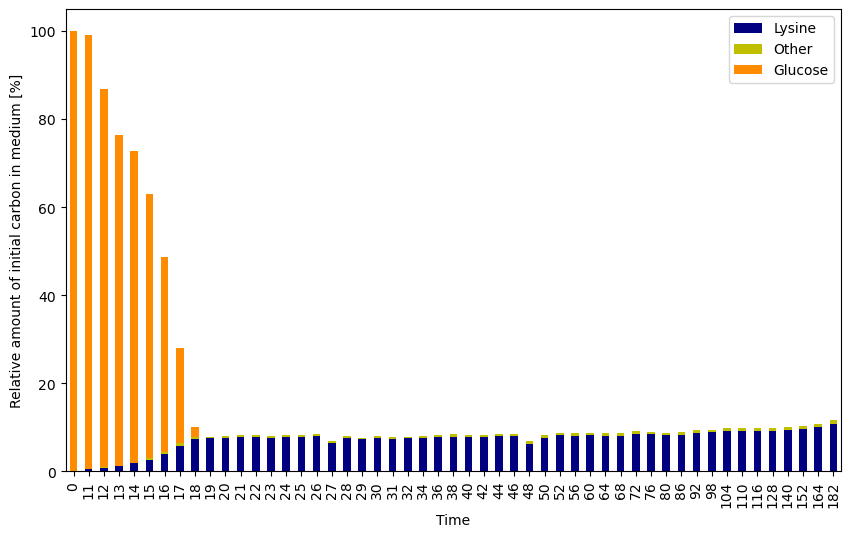

In [350]:
df_exo_carbon_others_norm = 100*df_exo_carbon_others/df_glucose['N carbons'].max()
ax = df_exo_carbon_others_norm.plot(kind='bar', stacked=True, color = colors2, figsize = (10,6))
ax.set_ylabel("Relative amount of initial carbon in medium [%]")

Text(0, 0.5, 'Carbon in medium [mol/L]')

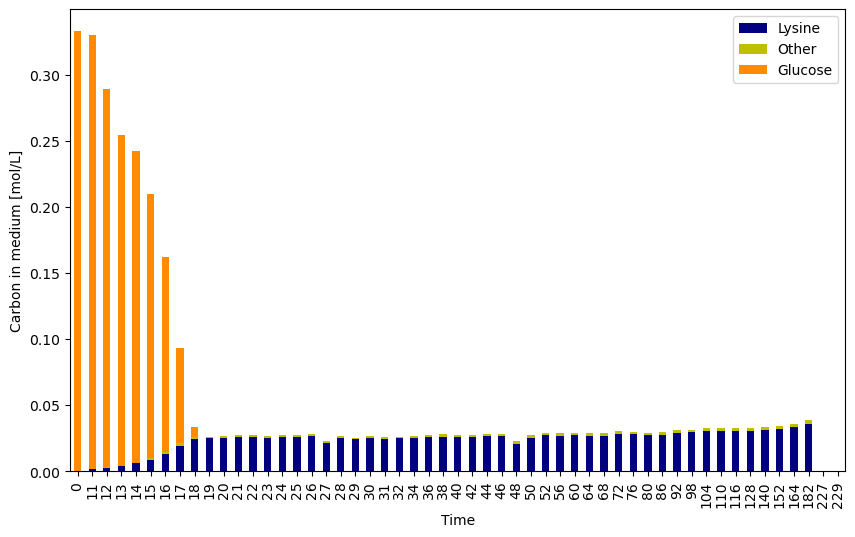

In [337]:
df_exo_carbon_others['Glucose'] = df_glucose['N carbons']
ax = df_exo_carbon_others.plot(kind='bar', stacked=True, color = colors2, figsize = (10,6))
ax.set_ylabel("Carbon in medium [mol/L]")

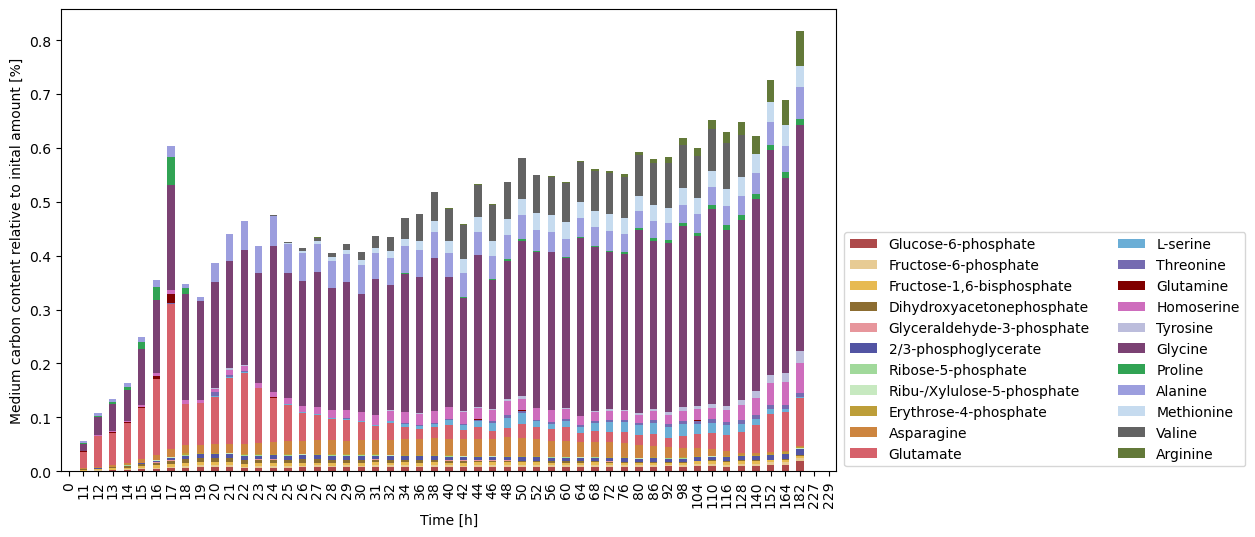

In [367]:
tmp = 100*df_exo_n_carbons.loc[:, other_idx]/df_glucose['N carbons'].max()
# tmp.dropna(inplace=True)
# cmap = colors.ListedColormap(cm.tab20b.colors[4:] + cm.tab20c.colors, name='tab40')
ax = tmp.plot(kind='bar', stacked=True, color = colors2, figsize = (10,6))
ax.set_ylabel("Medium carbon content relative to inital amount [%]")
ax.set_xlabel("Time [h]")
ax.legend(loc=(1.01, 0.01), ncol=2)

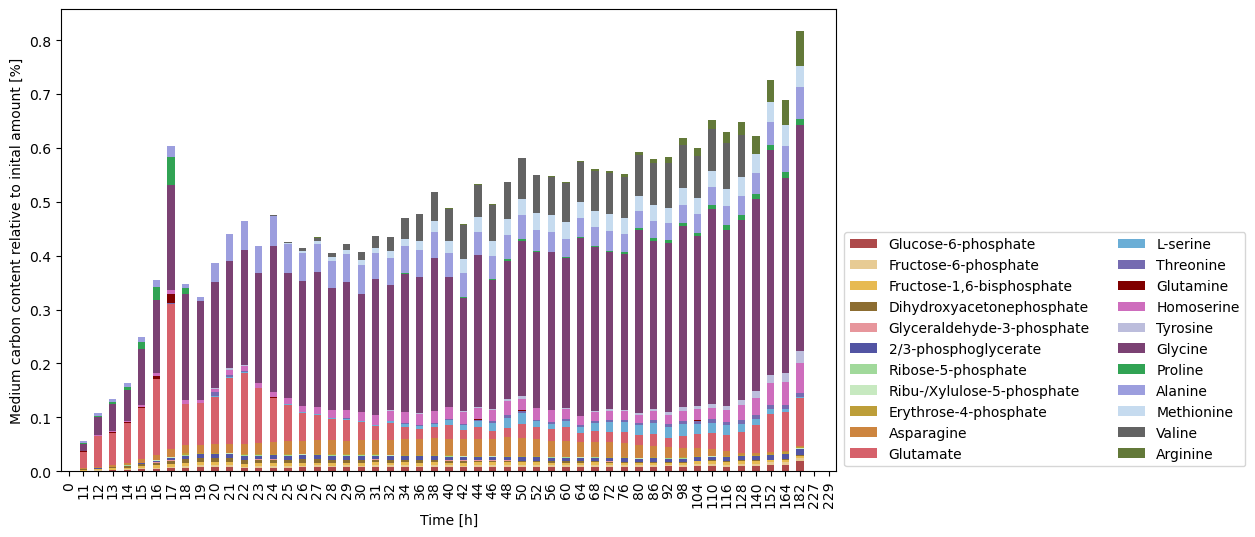

In [364]:
tmp = 100*df_exo_n_carbons.loc[:, other_idx]/df_glucose['N carbons'].max()
# cmap = colors.ListedColormap(cm.tab20b.colors[4:] + cm.tab20c.colors, name='tab40')
ax = tmp.plot(kind='bar', stacked=True, color = colors2, figsize = (10,6))
ax.set_ylabel("Medium carbon content relative to inital amount [%]")
ax.set_xlabel("Time [h]")
ax.legend(loc=(1.01, 0.01), ncol=2)

Text(0, 0.5, 'Change in extracellular concentration [Rel. inital C [%]]')

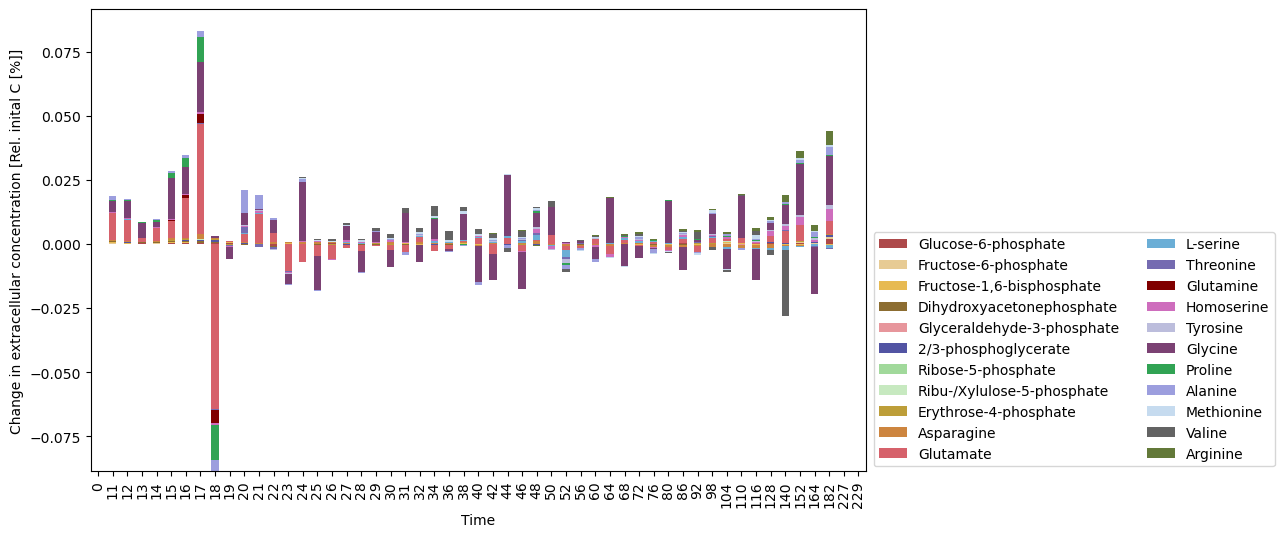

In [341]:
df_diff = df_exo_n_carbons.loc[:, other_idx].diff()*100
timestep = np.diff(df_exo_carbon_others.index)
ax = df_diff.plot(kind='bar', stacked=True, color = colors2, figsize = (10,6))
ax.legend(loc=(1.01, 0.01), ncol=2)
ax.set_ylabel('Change in extracellular concentration [Rel. inital C [%]]')

Text(0, 0.5, 'Change in extracellular carbon [Rel. to initial [%]]')

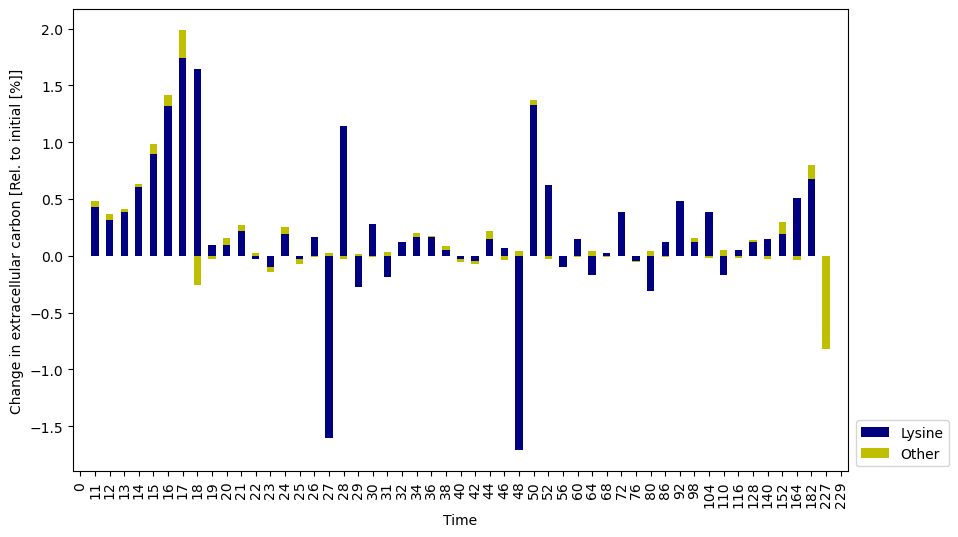

In [346]:
df_diff = df_exo_carbon_others_norm.diff()
df_diff.drop(columns='Glucose', inplace=True)
timestep = np.diff(df_exo_carbon_others.index)
ax = df_diff.plot(kind='bar', stacked=True, color = colors2, figsize = (10,6))
ax.legend(loc=(1.01, 0.01), ncol=1)
ax.set_ylabel('Change in extracellular carbon [Rel. to initial [%]]')

In [348]:
df_exo_carbon_others_norm

,Lysine,Other,Glucose
Time,,,
0,0.000000,0.000000,100.00
11,0.425348,0.056130,98.69
12,0.744345,0.108625,86.07
13,1.132280,0.134491,75.05
14,1.735203,0.163782,70.75
15,2.628776,0.249745,60.09
16,3.942714,0.354681,44.37
17,5.679418,0.604326,21.78
18,7.320039,0.347521,2.46


Text(0, 0.5, 'Change in extracellular concentration [Rel. inital C [%]]')

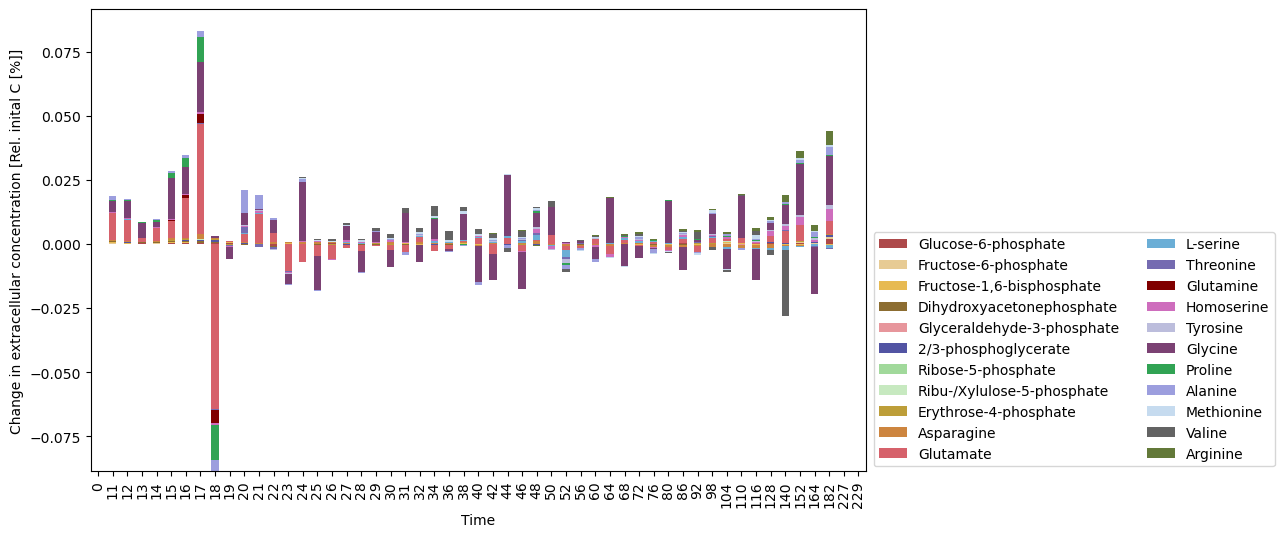

In [342]:
df_diff = df_exo_n_carbons.loc[:, other_idx].diff()*100
timestep = np.diff(df_exo_carbon_others.index)
ax = df_diff.plot(kind='bar', stacked=True, color = colors2, figsize = (10,6))
ax.legend(loc=(1.01, 0.01), ncol=2)
ax.set_ylabel('Change in extracellular concentration [Rel. inital C [%]]')

<AxesSubplot:xlabel='Time'>

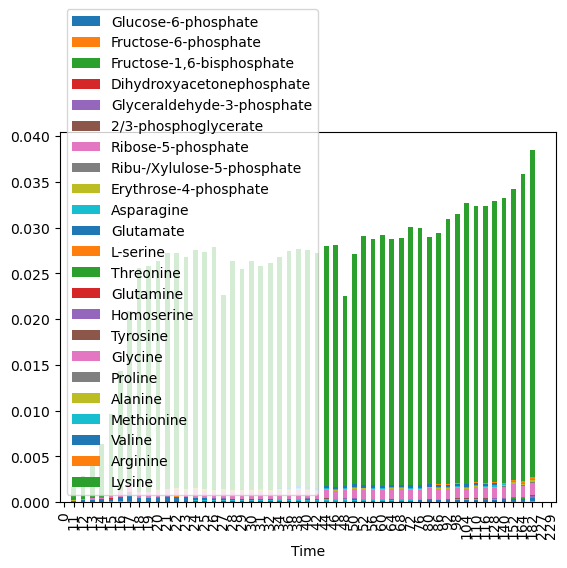

In [76]:
df_exo_n_carbons.plot(kind='bar', stacked=True)

In [77]:
df_exo_n_carbons['Glucose'] = df_glucose['N carbons']

In [78]:
df_diff = df_exo_n_carbons.diff()
timestep = np.diff(df_exo_carbon_others.index)

In [79]:
leaked = (df_diff[df_diff>0].sum(1))[1:]/timestep

In [80]:
consumed = (df_diff[df_diff<0].sum(1)*-1)[1:]/timestep

Text(0, 0.5, 'Relative carbon [%]')

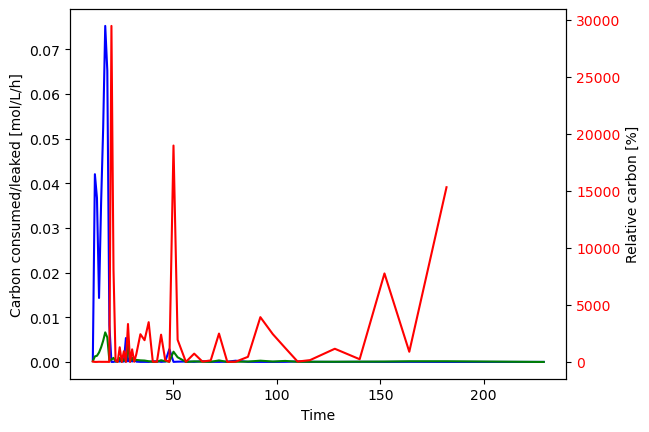

In [81]:
fig, ax = plt.subplots(1)
ax2 = ax.twinx()
consumed.plot(ax=ax, c = 'b')
leaked.plot(ax=ax, label = 'Leaked', c = 'g')
(100*leaked/consumed).plot(ax=ax2, c = 'r')
ax2.tick_params(axis='y', labelcolor='r')
ax.set_ylabel('Carbon consumed/leaked [mol/L/h]')
ax2.set_ylabel('Relative carbon [%]')

## B. licheniformis

In [368]:
organism = 'b_licheniformis'
data_folder =  Path("../data/{0}/".format(organism))


In [369]:
exometabolites_folder = Path(data_folder)

# Filenames
fn_exometabolites = exometabolites_folder / "{0}_exometabolites.csv".format(organism)
fn_exometabolites_std = exometabolites_folder / "{0}_exometabolites_std.csv".format(organism)
fn_OD = exometabolites_folder / "{0}_OD.csv".format(organism)
fn_glucose = exometabolites_folder / "{0}_glucose.csv".format(organism)

# Read files as dataframes
df_exometabolites = pd.read_csv(fn_exometabolites, index_col=0)
df_exometabolites_std = pd.read_csv(fn_exometabolites_std, index_col=0)
df_OD = pd.read_csv(fn_OD, index_col=0)

In [370]:
df_glucose = pd.read_csv(fn_glucose, index_col=0)
df_glucose.loc[0,:]=[16,0] # From paper (in g/L)

In [371]:
Mw_glc = 180.156
df_glucose['N carbons'] = 6*df_glucose['Glucose mean']/Mw_glc

In [372]:
# df_eexometabolites is in uM
df_exometabolites.loc[0,:]=0 # Assume none of the byproducts are present at start of cultivation

In [373]:
df_exometabolites

,G6P,F6P,FBP,DHAP,GA3P,23PG,PEP,PYR MS,R5P,RU5P+X5P,...,HIS,LYS,ARG,PYR,ORO,FUM,URA,AKG,SHI,ACT
Time,,,,,,,,,,,,,,,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.734667,0.432133,NaN,0.956000,0.276933,1.852000,0.729333,119.600000,0.325067,0.189733,...,4.049333,0.000000,5.586667,83.00,2.00,1.75,10.00,0.00,2.00,1694.50
2,1.701333,1.481333,2.533333,1.828000,0.379467,4.680000,1.917333,287.200000,1.025333,0.449333,...,4.048000,0.000000,6.080000,135.50,1.25,2.25,16.00,0.00,1.50,3134.25
3,2.758667,1.704000,2.080000,2.710667,0.606667,7.453333,2.970667,420.000000,1.650667,0.704000,...,3.344000,0.000000,4.454667,244.25,1.25,3.50,7.25,0.00,2.25,5075.50
4,3.622667,2.468000,1.000000,4.186667,0.838667,12.240000,4.613333,646.666667,2.668000,1.122667,...,2.954667,0.000000,3.205333,238.75,0.50,2.50,23.50,0.00,2.25,7828.50
5,5.320000,3.506667,1.320000,5.320000,1.426667,16.333333,5.946667,881.333333,4.613333,1.714667,...,2.572000,0.000000,3.465333,673.75,1.75,7.75,10.50,22.25,5.25,14462.25
6,9.253333,5.613333,1.413333,7.720000,2.238667,22.986667,7.773333,1380.000000,7.133333,2.646667,...,2.357333,0.000000,2.970667,968.50,0.00,14.00,23.00,46.50,5.50,20311.50
7,18.773333,9.386667,1.080000,10.146667,2.549333,29.146667,10.213333,2108.000000,10.186667,4.186667,...,1.784000,0.000000,2.918667,1521.50,2.00,41.50,25.50,111.00,7.00,27291.00
8,23.640000,11.680000,0.720000,13.040000,2.666667,34.693333,13.280000,2553.333333,14.360000,6.080000,...,1.470667,0.000000,2.944000,1877.50,4.00,76.50,62.00,145.00,7.00,34019.00


In [374]:
df_exometabolites.columns

Index(['G6P', 'F6P', 'FBP', 'DHAP', 'GA3P', '23PG', 'PEP', 'PYR MS', 'R5P',
       'RU5P+X5P', 'E4P', 'CIT', 'ACN', 'ICIT', 'AKG MS', 'FUM MS', 'ASN',
       'GLU', 'SER', 'ASP', 'GLN', 'HOM', 'TYR', 'GLY', 'PRO', 'ALA', 'MET',
       'VAL', 'PHE', 'LEU+ILEU', 'TRP', 'HIS', 'LYS', 'ARG', 'PYR', 'ORO',
       'FUM', 'URA', 'AKG', 'SHI', 'ACT'],
      dtype='object')

In [375]:
# met_abbreviations = [x.replace(" MS", "") for x in df_exometabolites.columns]

## map all units to mol/L carbon

In [376]:
n_carbon_dict = {}
for col in df_exometabolites.columns:
    try:
        keys = [x.strip() for x in met_abrv_to_id[col].split(',')]
    except (AttributeError, KeyError) as e:
        print('{0} not parsed into n_carbons'.format(col))
        continue
    else:
        n_carbon = 0
        for m_id in keys:
            m = model.metabolites.get_by_id('{0}_c'.format(m_id))
            n_carbon += m.elements['C']
        n_carbon = n_carbon/len(keys)
        n_carbon_dict[col] = n_carbon * df_exometabolites[col] *1e-6 # Convert from uM to M
    

PYR MS not parsed into n_carbons
AKG MS not parsed into n_carbons
FUM MS not parsed into n_carbons


In [377]:
df_exo_n_carbons = pd.DataFrame(n_carbon_dict, index = df_exometabolites.index)
df_exo_n_carbons.columns = [met_abrv_to_name[x] for x in df_exo_n_carbons.columns]

In [378]:
# df_exo_n_carbons.loc[0,:] = 0

In [379]:
glc_carbons_consumed = df_glucose.loc[0, 'N carbons'] - df_glucose.loc[:, 'N carbons']
carbons_in_medium = df_exo_n_carbons.sum(axis=1)

(0.0, 100.0)

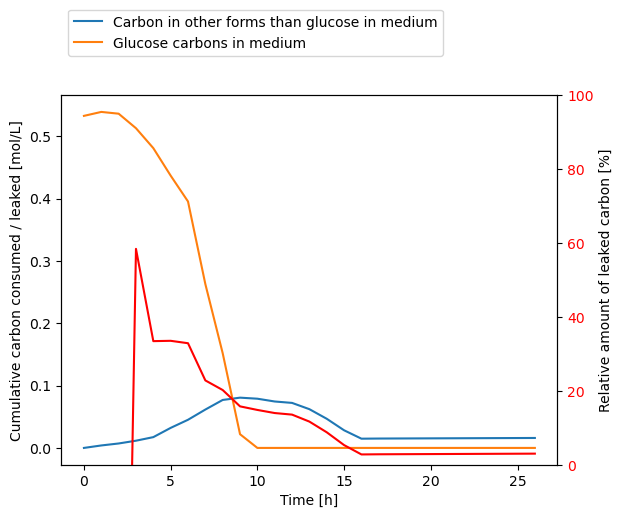

In [380]:
fig, ax = plt.subplots(1)
ax.plot(df_glucose.index, carbons_in_medium, label = 'Carbon in other forms than glucose in medium')
ax.plot(df_glucose.index,df_glucose.loc[:, 'N carbons'], label = "Glucose carbons in medium")
ax2 = ax.twinx()
ax2.plot(df_glucose.index, 100*carbons_in_medium/glc_carbons_consumed, label = 'Relative amount of leaked carbon', c = 'r')
ax.legend(loc = 'upper left', bbox_to_anchor=(0, 1.25))
ax.set_xlabel('Time [h]')
ax.set_ylabel('Cumulative carbon consumed / leaked [mol/L]')
ax2.set_ylabel('Relative amount of leaked carbon [%]')
ax2.tick_params(axis='y', labelcolor='r')
ax2.set_ylim(0, 100)


In [381]:
other_idx = df_exo_n_carbons.sum()/df_exo_n_carbons.sum().sum() < 0.005
df_exo_carbon_others = df_exo_n_carbons.loc[:, ~other_idx].copy()
df_exo_carbon_others.loc[:,'Other'] = df_exo_n_carbons.loc[:, other_idx].sum(axis=1)


Text(0, 0.5, 'Carbon in medium except glucose [mol/L]')

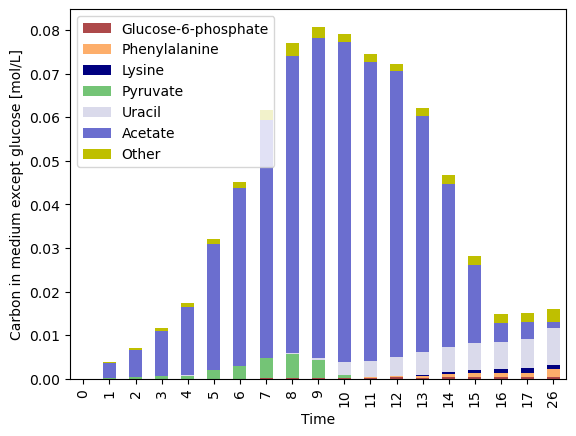

In [382]:
ax = df_exo_carbon_others.plot(kind='bar', stacked=True, color = colors2)
ax.set_ylabel("Carbon in medium except glucose [mol/L]")

Text(0, 0.5, 'Relative amount of initial carbon in medium [%]')

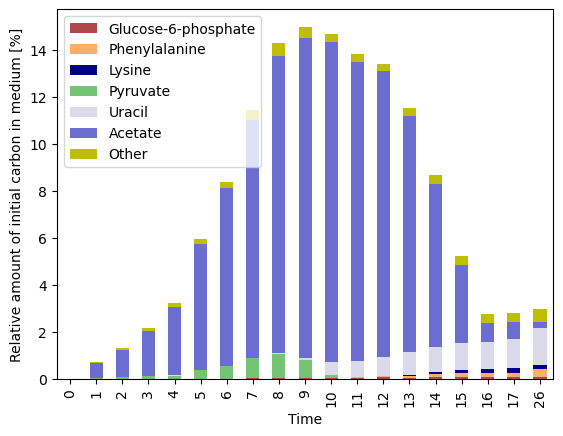

In [383]:
df_exo_carbon_others_norm = 100*df_exo_carbon_others/df_glucose['N carbons'].max()
ax = df_exo_carbon_others_norm.plot(kind='bar', stacked=True, color = colors2)
ax.set_ylabel("Relative amount of initial carbon in medium [%]")

Text(0, 0.5, 'Carbon in medium [mol/L]')

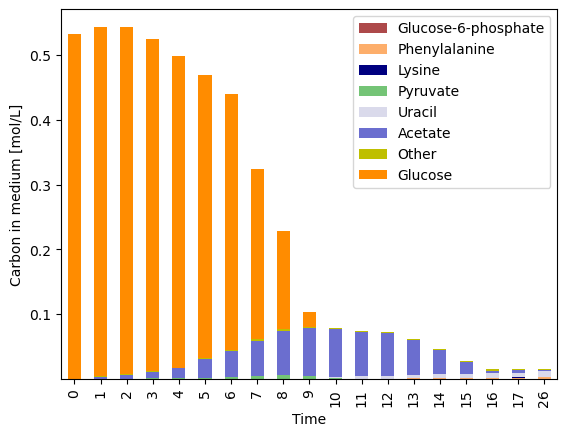

In [384]:
df_exo_carbon_others['Glucose'] = df_glucose['N carbons']
ax = df_exo_carbon_others.plot(kind='bar', stacked=True, color = colors2)
ax.set_ylabel("Carbon in medium [mol/L]")

Text(0, 0.5, 'Relative amount of initial carbon in medium [%]')

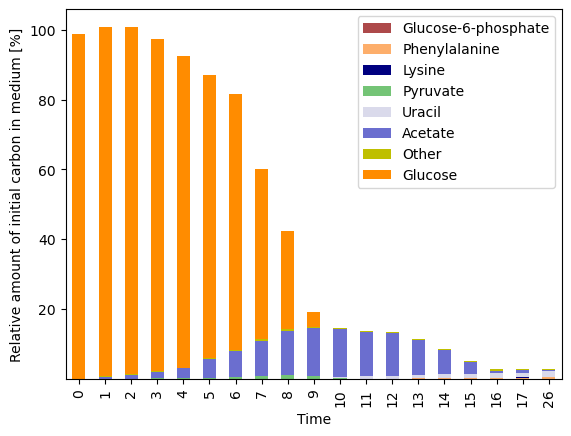

In [249]:
df_exo_carbon_others_norm['Glucose'] = 100*df_glucose['N carbons']/df_glucose['N carbons'].max()
ax = df_exo_carbon_others_norm.plot(kind='bar', stacked=True, color = colors2)
ax.set_ylabel("Relative amount of initial carbon in medium [%]")

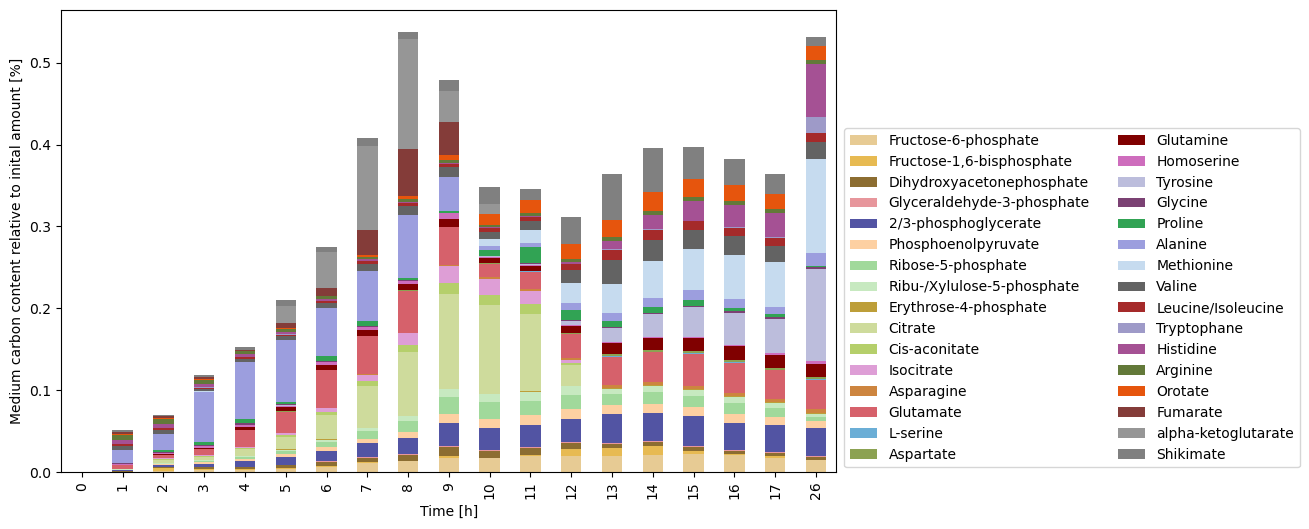

In [385]:
tmp = 100*df_exo_n_carbons.loc[:, other_idx]/df_glucose['N carbons'].max()
# cmap = colors.ListedColormap(cm.tab20b.colors[4:] + cm.tab20c.colors, name='tab40')
ax = tmp.plot(kind='bar', stacked=True, color = colors2, figsize = (10,6))
ax.set_ylabel("Medium carbon content relative to inital amount [%]")
ax.set_xlabel("Time [h]")
ax.legend(loc=(1.01, 0.01), ncol=2)

Text(0, 0.5, 'Change in extracellular carbon [Rel. to initial [%]]')

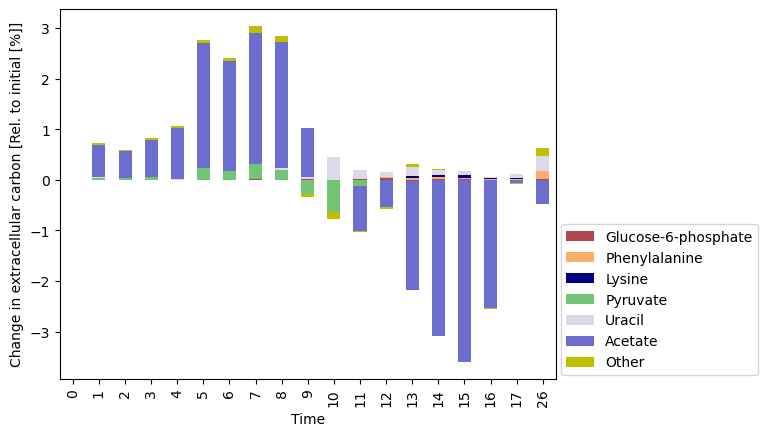

In [250]:
df_diff = df_exo_carbon_others_norm.diff()
df_diff.drop(columns='Glucose', inplace=True)
timestep = np.diff(df_exo_carbon_others.index)
ax = df_diff.plot(kind='bar', stacked=True, color = colors2)
ax.legend(loc=(1.01, 0.01), ncol=1)
ax.set_ylabel('Change in extracellular carbon [Rel. to initial [%]]')

Text(0, 0.5, 'Change in extracellular concentration [Rel. initial C [%]]')

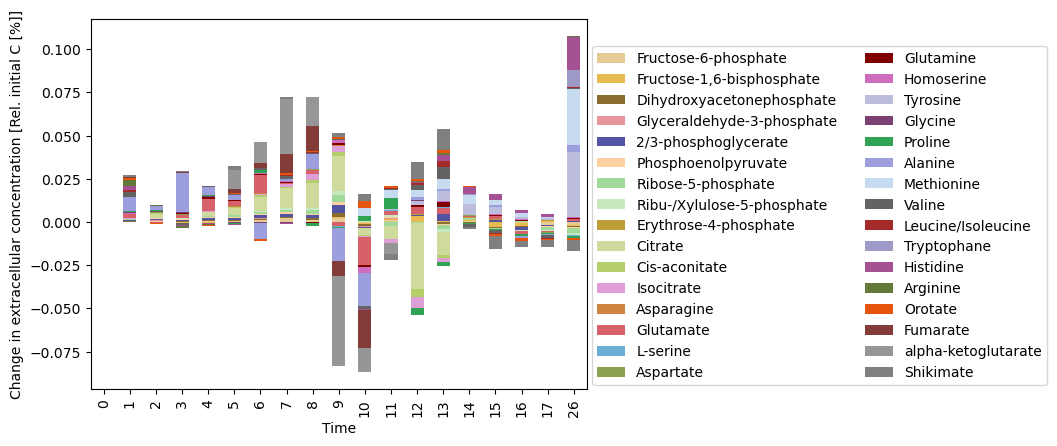

In [386]:
df_diff = df_exo_n_carbons.loc[:, other_idx].diff()*100
timestep = np.diff(df_exo_carbon_others.index)
ax = df_diff.plot(kind='bar', stacked=True, color = colors2)
ax.legend(loc=(1.01, 0.01), ncol=2)
ax.set_ylabel('Change in extracellular concentration [Rel. initial C [%]]')

<AxesSubplot:xlabel='Time'>

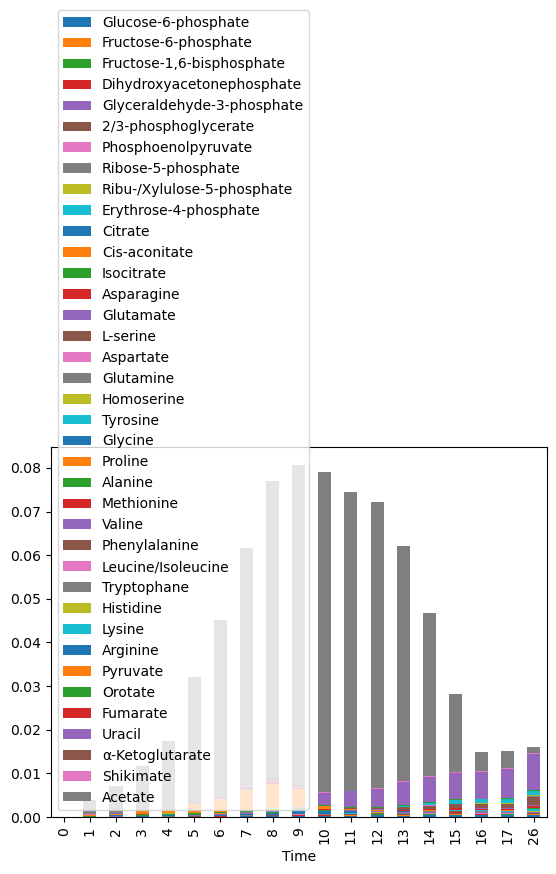

In [101]:
df_exo_n_carbons.plot(kind='bar', stacked=True)

In [102]:
df_exo_n_carbons['Glucose'] = df_glucose['N carbons']

In [103]:
df_diff = df_exo_n_carbons.diff()
timestep = np.diff(df_exo_carbon_others.index)

In [104]:
leaked = (df_diff[df_diff>0].sum(1))[1:]/timestep

In [105]:
consumed = (df_diff[df_diff<0].sum(1)*-1)[1:]/timestep

Text(0, 0.5, 'Relative carbon [%]')

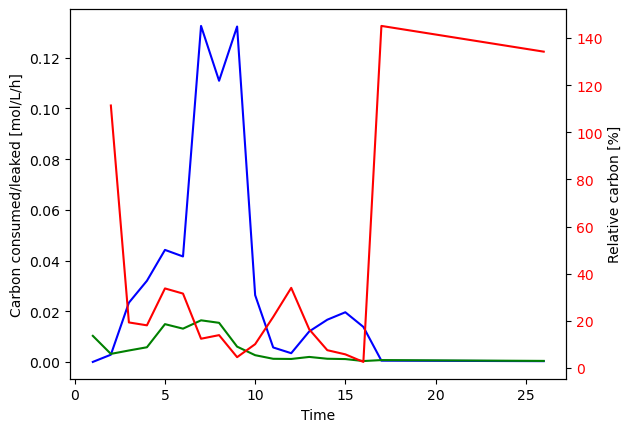

In [106]:
fig, ax = plt.subplots(1)
ax2 = ax.twinx()
consumed.plot(ax=ax, c = 'b')
leaked.plot(ax=ax, label = 'Leaked', c = 'g')
(100*leaked/consumed).plot(ax=ax2, c = 'r')
ax2.tick_params(axis='y', labelcolor='r')
ax.set_ylabel('Carbon consumed/leaked [mol/L/h]')
ax2.set_ylabel('Relative carbon [%]')